In [1]:
# SECTION 1: Environment Setup
import os
import zipfile
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from timm import create_model  # For PVT and EfficientNet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
# SECTION 2: Dataset Preparation (Training & Validation)

# Unzip training/validation dataset
train_val_zip_path = "/content/drive/MyDrive/Flame Dataset/Training.zip"
train_val_extract_path = "data"

with zipfile.ZipFile(train_val_zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_val_extract_path)

# Define dataset paths
# Corrected path: Remove the extra '/content' from the path
train_val_data_dir = os.path.join(train_val_extract_path, "Training") # Use 'Training' directly
# Alternatively train_val_data_dir = 'data/Training'

# Define transformations for training and validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load dataset
dataset = datasets.ImageFolder(root=train_val_data_dir, transform=transform)

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Verify classes
print("Classes:", dataset.classes)

Classes: ['Fire', 'No_Fire']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
# SECTION 3: Dataset Preparation (Testing)

# Unzip Testing.zip
testing_zip_path = "/content/drive/MyDrive/Flame Dataset/Test.zip"
testing_extract_path = "testing_data"

with zipfile.ZipFile(testing_zip_path, 'r') as zip_ref:
    zip_ref.extractall(testing_extract_path)

# Define test dataset path
# Replace "Test" with the actual folder name containing your test images
test_data_dir = os.path.join(testing_extract_path, "Test")

# Define transformations for the test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load the test dataset
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Verify classes
print("Test Dataset Classes:", test_dataset.classes)

Test Dataset Classes: ['Fire', 'No_Fire']


In [4]:
# SECTION 4: Model Selection

# PVT Model
pvt_model = create_model('pvt_v2_b2', pretrained=True, num_classes=2)  # Fire vs No Fire (binary classification)
pvt_model = pvt_model.to(device)

# EfficientNet Model
efficientnet_model = create_model('efficientnet_b0', pretrained=True, num_classes=2)
efficientnet_model = efficientnet_model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/101M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [5]:
# SECTION 5: Training Function

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


In [6]:
# SECTION 6: Validation Function

def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Validation Loss: {total_loss/len(val_loader):.4f}, Accuracy: {accuracy*100:.2f}%")


In [7]:
# SECTION 7: Testing Function (with Confusion Matrix)

def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Loss: {total_loss/len(test_loader):.4f}, Accuracy: {accuracy*100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


Epoch 1/10, Loss: 0.1890
Epoch 2/10, Loss: 0.2630
Epoch 3/10, Loss: 0.6588
Epoch 4/10, Loss: 0.6573
Epoch 5/10, Loss: 0.6574
Epoch 6/10, Loss: 0.6578
Epoch 7/10, Loss: 0.6573
Epoch 8/10, Loss: 0.6574
Epoch 9/10, Loss: 0.6572
Epoch 10/10, Loss: 0.6568
Validation Loss: 0.6581, Accuracy: 63.68%
Test Loss: 0.6755, Accuracy: 59.61%
Confusion Matrix:
[[5137    0]
 [3480    0]]


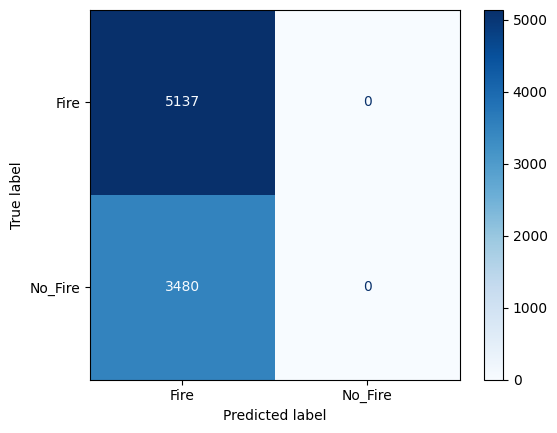

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10, Loss: 0.0448
Epoch 2/10, Loss: 0.0073
Epoch 3/10, Loss: 0.0073
Epoch 4/10, Loss: 0.0059
Epoch 5/10, Loss: 0.0122
Epoch 6/10, Loss: 0.0025
Epoch 7/10, Loss: 0.0056
Epoch 8/10, Loss: 0.0022
Epoch 9/10, Loss: 0.0039
Epoch 10/10, Loss: 0.0013
Validation Loss: 0.0046, Accuracy: 99.91%
Test Loss: 0.6775, Accuracy: 87.85%
Confusion Matrix:
[[4930  207]
 [ 840 2640]]


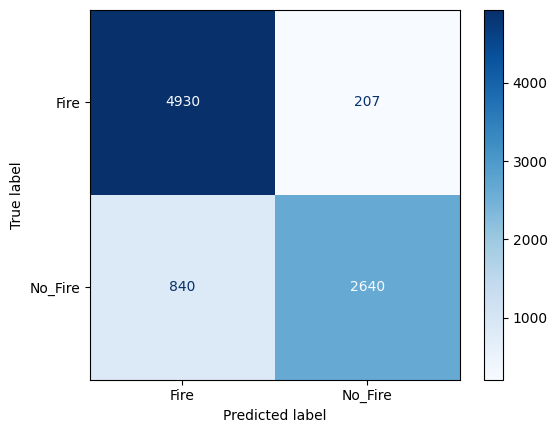

In [8]:
# SECTION 8: Training and Evaluation Workflow

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

# Training and Validation for PVT
pvt_optimizer = optim.AdamW(pvt_model.parameters(), lr=0.001, weight_decay=1e-4)
train_model(pvt_model, train_loader, criterion, pvt_optimizer, num_epochs=10)
validate_model(pvt_model, val_loader, criterion)

# Testing for PVT
test_model(pvt_model, test_loader, criterion)

# Training and Validation for EfficientNet
efficientnet_optimizer = optim.AdamW(efficientnet_model.parameters(), lr=0.001, weight_decay=1e-4)
train_model(efficientnet_model, train_loader, criterion, efficientnet_optimizer, num_epochs=10)
validate_model(efficientnet_model, val_loader, criterion)

# Testing for EfficientNet
test_model(efficientnet_model, test_loader, criterion)


In [9]:
# SECTION 9: Save Models

# Save trained models
torch.save(pvt_model.state_dict(), "pvt_fire_detection.pth")
torch.save(efficientnet_model.state_dict(), "efficientnet_fire_detection.pth")
